In [7]:
import os
import random
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")

In [2]:
idx = 2
sample_idx = f"{idx:03d}"
x = cv2.imread("../../datasets/generated/png/001/out-0.png")
y = load_mask(PNG_PATH, sample_idx, 48)


def Curvature(amplitude):
    
    def image(img, **kwargs):
        x = np.arange(0, img.shape[1], np.uint8)
        y = np.sin(x)
        
        return 255-img
    
    return A.Lambda(image=image)

transform = A.Compose([
    Curvature(),
])

aug_data = transform(image=x, mask=y)
x, y = aug_data["image"], aug_data["mask"]
plt.imshow(x)

TypeError: Curvature() missing 1 required positional argument: 'amplitude'

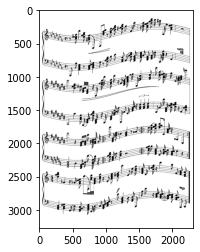

In [3]:
img = cv2.imread("../../datasets/generated/png/001/out-0.png")

amplitude = 100
frequency =  2* np.pi / (img.shape[1])
x = np.arange(0, img.shape[1])
y = (np.sin(x * frequency) + 1) * amplitude
y = y.astype(np.uint16)

res = np.ones_like(img) * 255
for i in range(img.shape[1]):
    neg = img.shape[0] - y[i]
    res[y[i]:, i:i+1] = img[:neg, i:i+1]
plt.imshow(res)

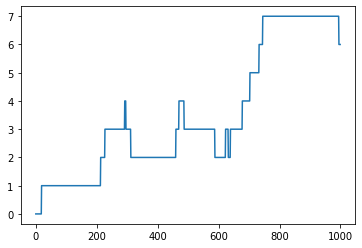

1000

In [2]:
import random
import math

def metropolis_hastings(target_distribution, proposal_distribution, initial_state, num_samples):
    """
    Generates samples from a target distribution using the Metropolis-Hastings algorithm.

    Parameters:
    - target_distribution: a function that returns the probability of a state under the target distribution
    - proposal_distribution: a function that returns a proposed state given the current state
    - initial_state: the starting state for the Markov chain
    - num_samples: the number of samples to generate

    Returns:
    - a list of samples from the target distribution
    """
    samples = []
    state = initial_state
    for _ in range(num_samples):
        proposed_state = proposal_distribution(state)
        acceptance_probability = min(1, target_distribution(proposed_state) / target_distribution(state))
        if random.random() < acceptance_probability:
            state = proposed_state
        samples.append(state)
    return samples

def target_distribution(state):
    """
    Returns the probability of a thickness under the target distribution.
    In this case, the target distribution is a symmetric binomial distribution.
    """
    n = 8    # number of states
    p = 0.5  # probability of success in each trial
    return math.comb(n, state) * p**state * (1-p)**(n-state)

def proposal_distribution(thickness, num_states, P):
    """
    Returns a proposed thickness given the current thickness, the number of states, and the probability matrix.
    """
    # Look up the row of the matrix corresponding to the current thickness
    row = P[thickness]

    # Generate a random number between 0 and 1
    r = random.random()
    
    # Determine the next thickness based on the probabilities in the row
    for i in range(num_states):
        if r < sum(row[:i+1]):
            return i
    
    # If the random number is greater than the sum of the probabilities in the row, return the last state
    return num_states - 1

# Define the number of states and the probability matrix
num_states = 8
c = 0.96
d = (1 - c) / 2
P = [
    [c, d, 0, 0, 0, 0, 0, 0],
    [d, c, d, 0, 0, 0, 0, 0],
    [0, d, c, d, 0, 0, 0, 0],
    [0, 0, d, c, d, 0, 0, 0],
    [0, 0, 0, d, c, d, 0, 0],
    [0, 0, 0, 0, d, c, d, 0],
    [0, 0, 0, 0, 0, d, c, d],
    [0, 0, 0, 0, 0, 0, d, c],
]

# Generate 1000 samples from the target distribution using the modified proposal distribution
samples = metropolis_hastings(target_distribution, lambda x: proposal_distribution(x, num_states, P), 0, 1000)

# Plot the histogram of the samples
import matplotlib.pyplot as plt
plt.plot(samples)
plt.show()
np.unique(samples)
len(samples)

In [8]:
idx = 1
sample_idx = f"{idx:03d}"

staff_mask = load_mask(PNG_PATH, sample_idx, 48)
staff_lines = load_stafflines(PNG_PATH, BBOX_PATH, sample_idx)

staff_lines

array([[  74, 2267,  193,  196],
       [  74, 2267,  217,  219],
       [  74, 2267,  240,  242],
       [  74, 2267,  263,  265],
       [  74, 2267,  286,  288],
       [  74, 2267,  612,  614],
       [  74, 2267,  635,  637],
       [  74, 2267,  659,  661],
       [  74, 2267,  682,  684],
       [  74, 2267,  705,  707],
       [  74, 2268,  937,  939],
       [  74, 2268,  960,  963],
       [  74, 2268,  984,  986],
       [  74, 2268, 1007, 1009],
       [  74, 2268, 1030, 1032],
       [  74, 2268, 1379, 1381],
       [  74, 2268, 1402, 1404],
       [  74, 2268, 1426, 1428],
       [  74, 2268, 1449, 1451],
       [  74, 2268, 1472, 1474],
       [  74, 2266, 1739, 1742],
       [  74, 2266, 1763, 1765],
       [  74, 2266, 1786, 1788],
       [  74, 2266, 1809, 1811],
       [  74, 2266, 1832, 1834],
       [  74, 2266, 2054, 2056],
       [  74, 2266, 2077, 2079],
       [  74, 2266, 2100, 2102],
       [  74, 2266, 2123, 2125],
       [  74, 2266, 2146, 2149],
       [  

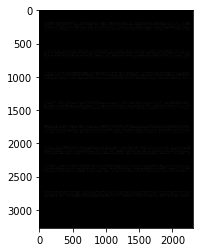

In [18]:
tmp = np.zeros_like(staff_mask)

is_gap = False
p = 0.8
for x0, x1, y0, y1 in staff_lines:
    for x in range(x0, x1 + 1):
        if random.random() > p:
            tmp[y0:y1, x:x+1] = 255

plt.imshow(tmp, cmap="gray")
Image.fromarray(255-tmp).show()

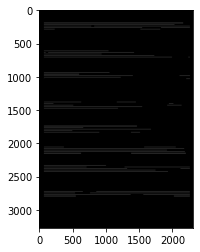

In [27]:
tmp = np.zeros_like(staff_mask)

is_gap = False
p = 0.8
n = 18
for x0, x1, y0, y1 in staff_lines:
    gap_total = int((x1 - x0) * p)
    
    # split total gap into n random sized gaps
    r = np.array(list(range(gap_total)))
    np.random.shuffle(r)
    tp = r[:n+1] + x0

    is_gap = False
    i = 0
    for x in range(x0, x1 + 1):
        if not is_gap:
            tmp[y0:y1, x:x+1] = 255
        if i < len(tp) and x == tp[i]:
            is_gap = not is_gap
            i += 1

plt.imshow(tmp, cmap="gray")
Image.fromarray(255-tmp).show()